<a href="https://colab.research.google.com/github/dodonas/DL_Final_Project_GAN/blob/master/DL_FINAL_PROJECT_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks - Afeka, Deep Learning
# Final project - Implementing DCGANs in Keras

# Submitters

[Andrey Dodon](https://www.kaggle.com/andreydodon) - ID 317858298

[Pazit Lazar](https://il.linkedin.com/in/pazit-lazar-85012272) - ID 204059919

[Erez Mahalu](https://il.linkedin.com/in/erez-mahalu-589388109) - ID 305465619

[Ekaterina Natanov](https://il.linkedin.com/in/ekaterina-natanov-0960135a) - ID ??????????

# Document reference
[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)<br> 
This document implements a DCGAN as follows:

* No pre-processing was applied to training images besides scaling to the range of the **Tanh activation** function [-1, 1]. 
* All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. 
* All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. 
* In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
* Used the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). Adam is relatively easy to configure where the default configuration parameters do well on most problems. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.


---


**Our notes**: we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.


# Architecture guidelines

* Replace any pooling layers with [strided](https://deepai.org/machine-learning-glossary-and-terms/stride) convolutions (discriminator) and [fractional-strided convolutions (generator)](https://deepai.org/machine-learning-glossary-and-terms/fractionally-strided-convolution).
* Use [batchnorm](https://en.wikipedia.org/wiki/Batch_normalization) in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

# Generator examples
The code below will generate faces similar to these.  While these faces are not perfect, they demonstrate how we can construct and train a GAN on our own.

In [24]:
from IPython.display import Image
Image(url='https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/output/ganOutput.gif')

# Quick reminder
As discussed during the ZOOM presentation, the GAN is made up of two different neural networks: the Discriminator and the Generator.  The generator generates the images, while the discriminator detects if a face is real or was generated.  These two neural networks work as shown below:<br>
![GAN](https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/img/gan_flow.png "GAN architecture")

The discriminator accepts an image as its input and produces number that is the probability of the input image being real.  The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

# Imports
The following packages will be used to implement a basic GAN system in Python/Keras.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

# Helpers

In [7]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}H:{:>02}M:{:>05.2f}sec".format(h, m, s)

# Setup
The constants below define how the GANs will be created for this presentation.<br>The higher the resolution, the more memory will be needed.<br>Higher resolution will also result in longer run times.<br>For Google CoLab (with GPU) 128x128 resolution is as high as can be used (due to memory).<br>Note that the resolution is specified as a multiple of 32.<br>So **GENERATE_RES** of 1 is 32, 2 is 64, etc.<br>
Note: GENERATE_RES 4 or higher will blow Google CoLab's memory and have not been tested extensivly.

We used [Kaggle Faces Dataset](https://www.kaggle.com/gasgallo/faces-data-new)

In [4]:
%%capture
!rm -rf archive.zip
!wget https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/input/archive.zip
!rm -rf images
!unzip archive.zip

--2021-12-26 09:14:51--  https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/input/archive.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/input/archive.zip [following]
--2021-12-26 09:14:51--  https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/input/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46903742 (45M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  44.73M   218MB/s    in 0.2s    

2021-12-26 09:14:53 (218 MB/s) - ‘archive.zip’ saved [46903742/4690374

In [6]:
# Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_RES = 3 
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = './images'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


Next we will load and preprocess the images.<br>Image set has 7864 images.  Can take over an hour<br>Because of this we store the processed file as a binary in a 'binary' folder.<br>This way we can simply reload the processed training data and quickly use it.<br>It is most efficient to only perform this operation once.<br>The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [9]:
!mkdir binary

In [10]:
training_binary_path = os.path.join('./binary',
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  # faces_path = './images'
  for filename in tqdm(os.listdir(DATA_PATH)):
      path = os.path.join(DATA_PATH,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: ./binary/training_data_96_96.npy
Loading training images...


100%|██████████| 7864/7864 [00:14<00:00, 558.99it/s]


Saving training image binary...
Image preprocess time: 0H:00M:17.96sec


We will use a TensorFlow **Dataset** object to actually hold the images.<br>This allows the data to be quickly shuffled and divided into the appropriate batch sizes for training.  

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Next we actually build the discriminator and the generator.<br>Both will be trained with the Adam optimizer.<br>Adam optimization is a stochastic gradient descent method that is based<br>on adaptive estimation of first-order and second-order moments.<br>According to [Kingma et al., 2014](http://arxiv.org/abs/1412.6980), the method is "computationally efficient,<br>has little memory requirement, invariant to diagonal rescaling of gradients,<br>and is well suited for problems that are large in terms of data/parameters".

# Generator

In [12]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

# Discriminator

In [13]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [14]:
!rm -rf output
!mkdir output

In [15]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = './output'
  if not os.path.exists('./output'):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

# Initial impression from the Generator

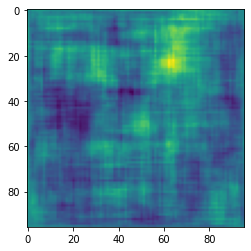

In [16]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

# Initial impression from the Discriminator

In [17]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50035995]], shape=(1, 1), dtype=float32)


Loss functions must be developed that allow the generator and discriminator to be trained in an adversarial way.<br>Because these two neural networks are being trained independently they must be trained in two separate passes.<br>This requires two separate loss functions and also two separate updates to the gradients.<br>When the discriminator's gradients are applied to decrease the discriminator's loss it is important<br>that only the discriminator's weights are update.  It is not fair, nor will it produce good results, to adversarially damage<br>the weights of the generator to help the discriminator.  A simple backpropagation would do this.  It would simultaneously<br>affect the weights of both Generator and Discriminator to lower whatever loss it was assigned to lower.<br>
![GAN](https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/img/g_d.png "Visualization of GAN’s progression")<br>
Here a training set is generated with an equal number of real and fake images.<br>The real images are randomly sampled (chosen) from the training data.<br>An equal number of random images are generated from random seeds.<br>For the discriminator training set, the $x$ contains the input images and the $y$<br> contains a value of 1 for real images and 0 for generated ones.<br>
![GAN](https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/img/gan_fig_3.png "Visualization of GAN’s progression")<br>
For the Generator training set, the $x$ contains the random seeds to<br>generate images and the $y$ always contains the value of 1, because the optimal<br>is for the generator to have generated such good images that the Discriminator was fooled into assigning them a probability near 1.

The methods below return helper functions to compute cross-entropy loss

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

The following function is where most of the training takes place for both the discriminator and the generator.<br>This function was based on the GAN provided by the [TensorFlow Keras exmples](https://www.tensorflow.org/tutorials/generative/dcgan) documentation.<br>The first thing you should notice about this function is that it is annotated with the **tf.function** annotation.<br>This causes the function to be precompiled and improves performance.<br>
<br>
This function trans differently than the code we previously saw for training.<br>This code makes use of **GradientTape** to allow the discriminator and generator to be trained together, yet separately. 

In [20]:
# @tf.function decorator before your code will create a graph for that piece of code.
# which is usually more performant and python independent
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [21]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

In [22]:
!rm -rf generated
!mkdir generated

In [ ]:
!zip -r ./ganOutput.zip ./output

In [24]:
generator.save(os.path.join('./generated',"face_generator.h5"))